# Import the libraries

In [23]:
import tensorflow as tf
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout

# Load the Dataset

In [24]:
x_test = nm.array(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Test/x_test.csv"))
x_train = nm.array(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Train/x_train.csv"))
y_test = nm.array(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Test/y_test.csv"))
y_train = nm.array(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Train/y_train.csv"))

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Pre-processing

In [26]:
nm.random.seed(30)

x_train = x_train/255
x_test = x_test/255

x_train= x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28,28,1))

# Create Own Model

In [27]:
model = Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), strides = 1, activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), strides = 1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(32, (3, 3), strides = 1, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

model.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)      

# Fit the Model

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/100
375/375 [==============================] - 7s 11ms/step - loss: 0.3970 - accuracy: 0.8471 - val_loss: 1.6919 - val_accuracy: 0.6046
Epoch 2/100
375/375 [==============================] - 6s 15ms/step - loss: 0.2547 - accuracy: 0.9052 - val_loss: 0.2936 - val_accuracy: 0.8884
Epoch 3/100
375/375 [==============================] - 5s 13ms/step - loss: 0.2169 - accuracy: 0.9197 - val_loss: 0.1918 - val_accuracy: 0.9290
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 0.1933 - accuracy: 0.9296 - val_loss: 0.1864 - val_accuracy: 0.9332
Epoch 5/100
375/375 [==============================] - 3s 9ms/step - loss: 0.1782 - accuracy: 0.9347 - val_loss: 0.2137 - val_accuracy: 0.9192
Epoch 6/100
375/375 [==============================] - 3s 7ms/step - loss: 0.1661 - accuracy: 0.9395 - val_loss: 0.1680 - val_accuracy: 0.9402
Epoch 7/100
375/375 [==============================] - 3s 8ms/step - loss: 0.1588 - accuracy: 0.9418 - val_loss: 0.1611 - val_accuracy: 0.9

# Generate the Encoded layers for Visual Representation

In [29]:
encoder_model = Model(inputs=model.input, outputs=model.layers[-2].output)
encoder_output = encoder_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


## 4.1 PCA

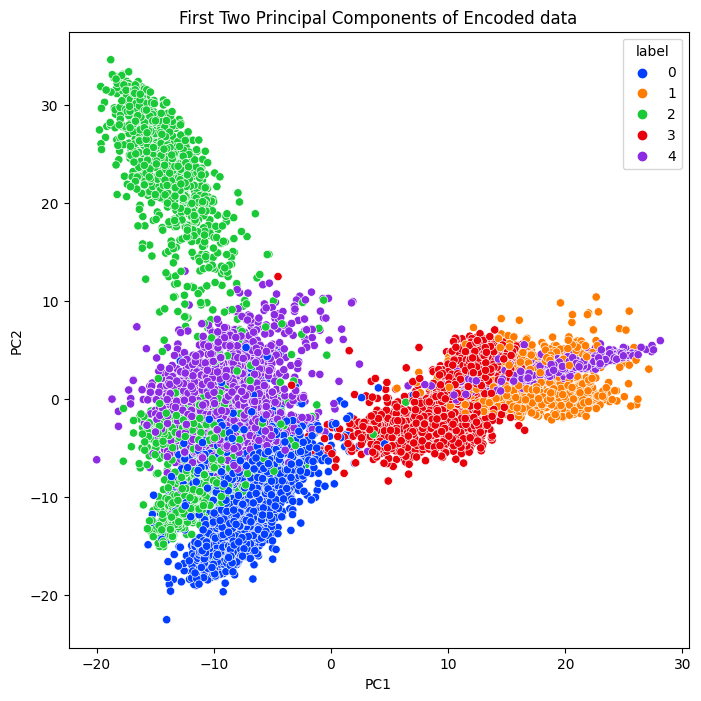

In [30]:
# Perform PCA on the encoded data
pca = PCA(n_components=2)
pca_output = pca.fit_transform(encoder_output)

# Visualize the encoded data
palette = sns.color_palette('bright', 5)
df_pca = pd.DataFrame(pca_output, columns=['PC1', 'PC2'])
df_pca['label'] = y_test

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First Two Principal Components of Encoded data')
plt.show()

## 4.2 DBScan

<Figure size 800x800 with 0 Axes>

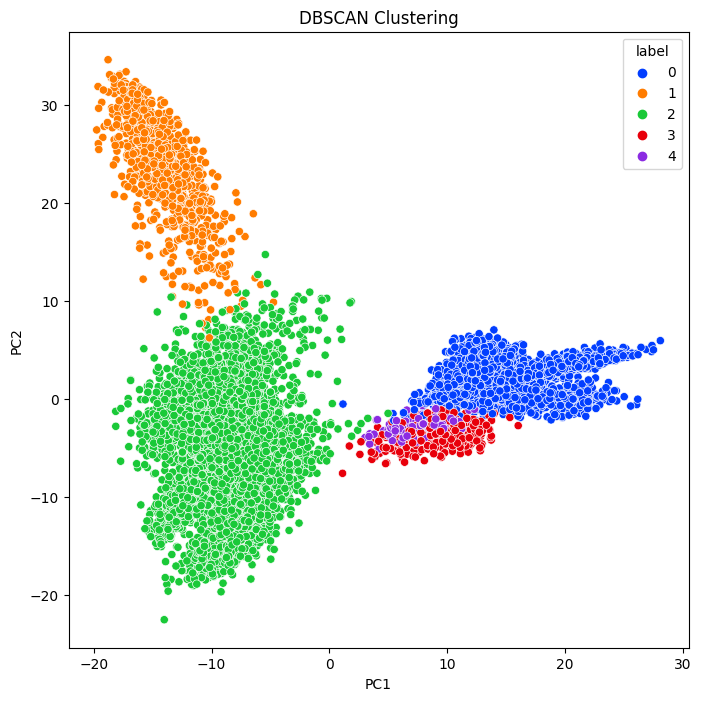

In [31]:
# DBSCAN
dbscan = DBSCAN(eps=14, min_samples=90)
dbscan_labels = dbscan.fit_predict(encoder_output)

pca_output_filt = pca_output[dbscan_labels != -1]
dbscan_labels_filt = dbscan_labels[dbscan_labels != -1]
# Create a scatter plot of the first two principal components with DBScan clustering
plt.figure(figsize=(8,8))
df_dbscan = pd.DataFrame({'x': pca_output_filt[:,0], 'y': pca_output_filt[:, 1], 'label': dbscan_labels_filt})
plt.figure(figsize=(8,8))
sns.scatterplot(data=df_dbscan, x='x', y='y', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering')
plt.show()

## 4.3 K-means Clustering

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Figure size 800x800 with 0 Axes>

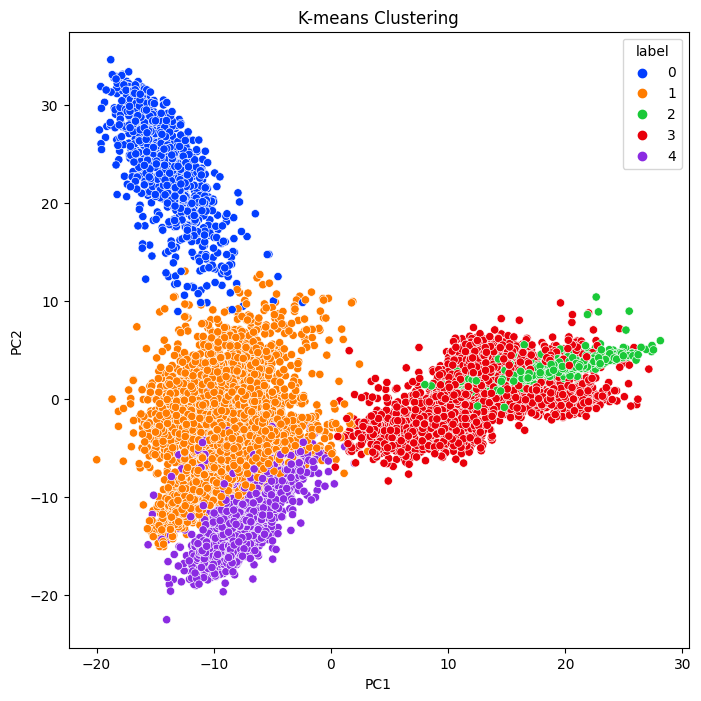

In [32]:
# K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(encoder_output)

# Create a scatter plot of the first two principal components with k-means clustering
plt.figure(figsize=(8,8))
df_dbscan = pd.DataFrame({'x': pca_output[:,0], 'y': pca_output[:, 1], 'label': kmeans_labels})

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_dbscan, x='x', y='y', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering')
plt.show()

## 4.3 T-SNE

<Figure size 800x800 with 0 Axes>

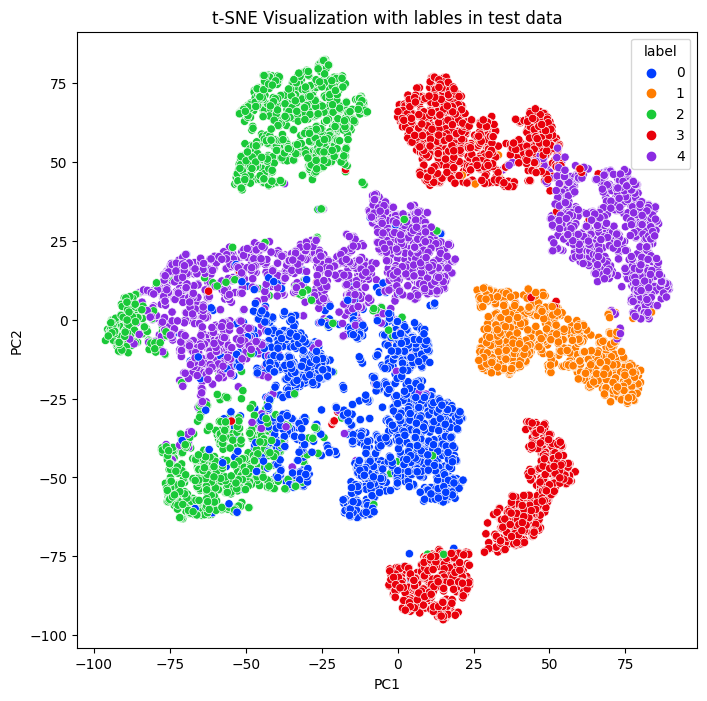

<Figure size 800x800 with 0 Axes>

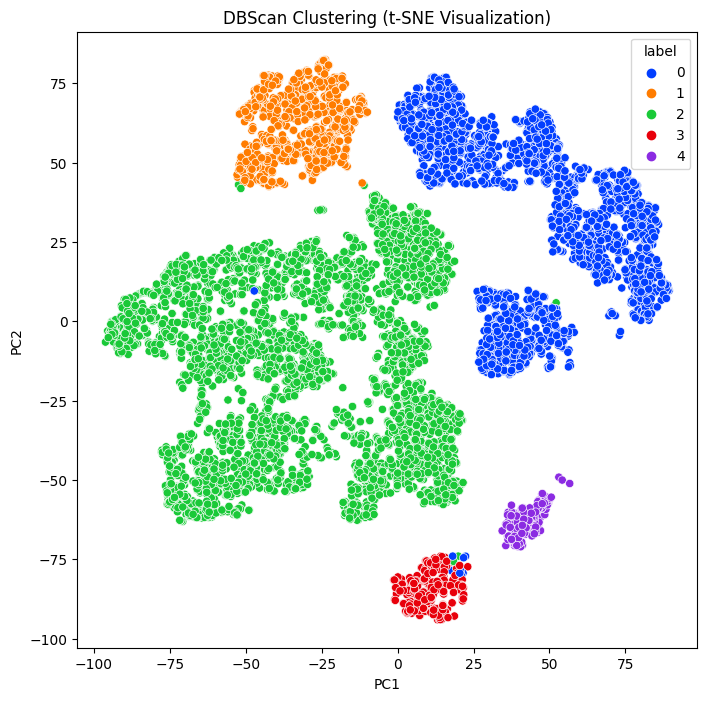

<Figure size 800x800 with 0 Axes>

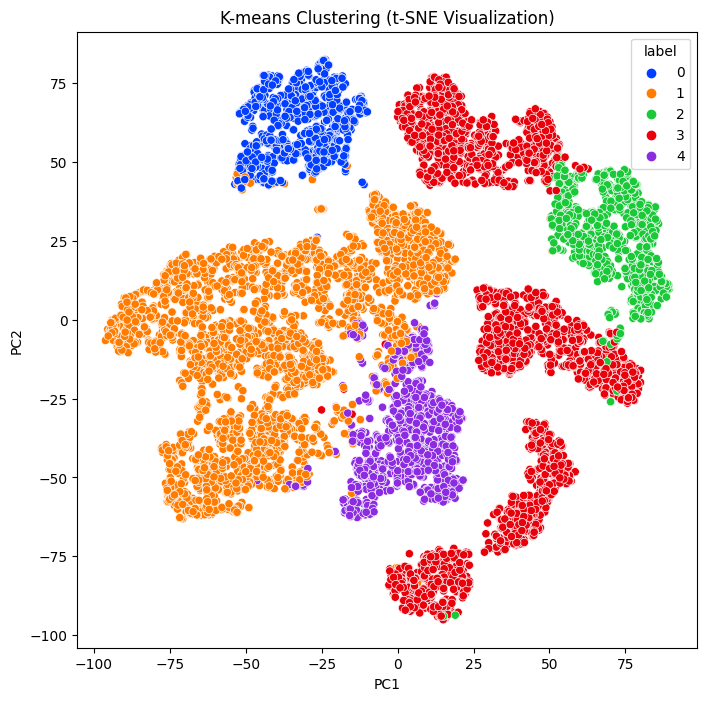

In [33]:
# Create a t-SNE embedding of the PCA-reduced data
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
x_test_tsne = tsne.fit_transform(encoder_output)

# Visualize the t-SNE with output label results
plt.figure(figsize=(8,8))
df_tsne = pd.DataFrame({'x': x_test_tsne[:, 0], 'y': x_test_tsne[:, 1]})
df_tsne['label'] = y_test

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('t-SNE Visualization with lables in test data')
plt.show()

tsne_output_filt = x_test_tsne[dbscan_labels != -1]

# Visualize the t-SNE with DBSCAN clustering labels
plt.figure(figsize=(8,8))
df_dbscan_tsne = pd.DataFrame({'x': tsne_output_filt[:, 0], 'y': tsne_output_filt[:, 1], 'label': dbscan_labels_filt})

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_dbscan_tsne, x='x', y='y', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBScan Clustering (t-SNE Visualization)')
plt.show()

# Visualize the t-SNE with K-means clustering labels
plt.figure(figsize=(8,8))
df_kmeans_tsne = pd.DataFrame({'x': x_test_tsne[:, 0], 'y': x_test_tsne[:, 1], 'label': kmeans_labels})

plt.figure(figsize=(8,8))
sns.scatterplot(data=df_kmeans_tsne, x='x', y='y', hue='label', palette=palette)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering (t-SNE Visualization)')
plt.show()

## 4.4 Display images based upon clustering

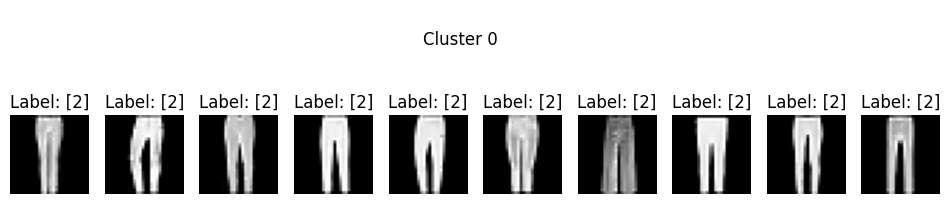

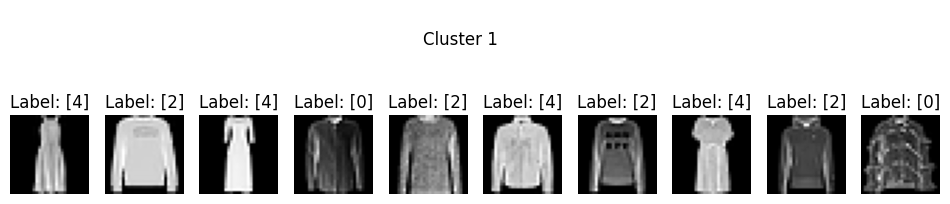

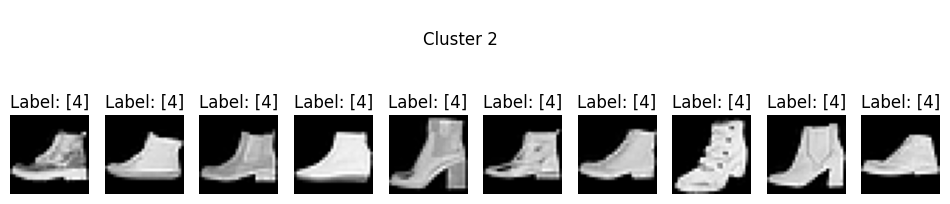

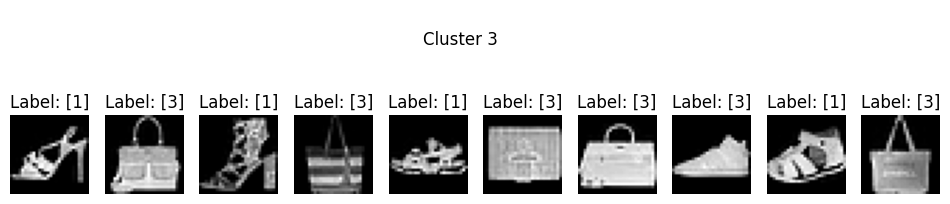

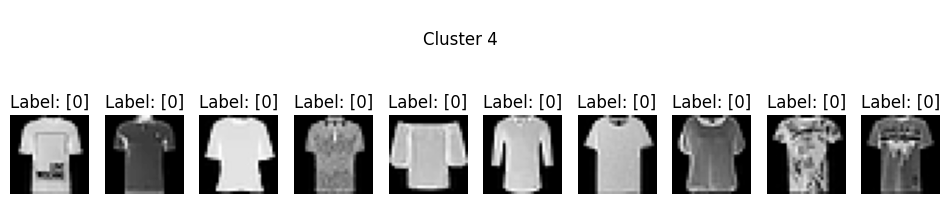

In [34]:
import random

# Define the number of images to display from each cluster
num_display_images = 10

# Get the labels for the original images
labels = y_test

# Display a random selection of images from each cluster
for cluster in set(kmeans_labels):
    # Get the indices of images in the current cluster
    cluster_indices = np.where(kmeans_labels == cluster)[0]
    # Randomly select a subset of images from the cluster
    display_indices = random.sample(list(cluster_indices), num_display_images)
    
    # Display the images and their label values
    fig, axs = plt.subplots(1, num_display_images, figsize=(12, 3))
    fig.suptitle('\nCluster ' + str(cluster))
    for i, idx in enumerate(display_indices):
        axs[i].imshow(x_test[idx], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title('Label: ' + str(labels[idx]))
    plt.show()